# Heterogeneous poroelastic footing problem

In [ ]:
%%capture
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [ ]:
from fenics import *
from mshr import *
import matplotlib.pyplot as plt
import numpy as np

## 3 field-formualtion with total pressure

In [ ]:
# mesh generation
#mesh = UnitSquareMesh(32, 32, 'crossed')
square = Rectangle(Point(0.0, 0.0), Point(1.0, 1.0))
mesh = generate_mesh(square, 32)

# definition of the lowest-order Taylor-Hood finite element pair
U = VectorElement('CG', mesh.ufl_cell(), 2)
Q = FiniteElement('CG', mesh.ufl_cell(), 1)
P = FiniteElement('CG', mesh.ufl_cell(), 2)
X = FunctionSpace(mesh, MixedElement([U, Q, P]))

# problem data
lam = Constant(2e4)
mu  = Constant(1.2e5)
c_0 = Constant(0.0)
alpha = Constant(1.0)
kappa = Expression('near(x[0], 0.5, 0.2) & near(x[1], 0.5, 0.2) ? 0.01 : 0.000001', degree=0)

beta = alpha/lam
gamma = c_0 + alpha**2/lam

f = Constant([0.0]*2)   # volumetric force
g = Constant(0.0)       # fluid source term
t_n = Expression(('0.0', '2e5*x[1]*x[0]*(x[0]-1)'), t=0.0, degree=2)

dt = 0.01
T = 0.05

# boundary conditions
def boundary(x, on_boundary):
    return on_boundary

def not_top(x, on_boundary):
    return on_boundary and not near(x[1], 1.0)

bc_u = DirichletBC(X.sub(0), Constant((0.0, 0.0)), not_top)
bc_p = DirichletBC(X.sub(2), 0, boundary)
bcs = [bc_u, bc_p]

In [ ]:
# discrete problem formulation
u, phi, p = TrialFunctions(X)
v, psi, q = TestFunctions(X)

x_old = Function(X)
u_old, phi_old, p_old = split(x_old)

a1 = (2.0 * mu * inner(sym(grad(u)), sym(grad(v))) - phi * div(v)) * dx
a2 = (div(u) + phi/lam - beta * p) * psi * dx
a3 = (beta * phi *q - gamma * p * q - dt * inner(kappa*grad(p), grad(q))) * dx
a = a1 + a2 + a3

L = (dot(f, v) + dt*g*q + beta*phi_old*q - gamma*p_old*q) * dx + dot(t_n, v) * ds  

0.0
solving step 0.01
solving step 0.02
solving step 0.03
solving step 0.04
solving step 0.05


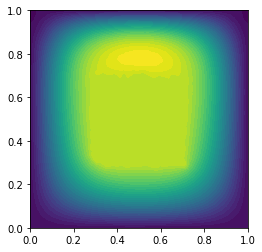

In [ ]:
# advance in time and post-process
time = 0.0
print(time)

x = Function(X)
u, phi, p = x.split()
u.rename('displacement', 'displacement')
p.rename('pressure', 'pressure')

ufile = File('displacement.pvd')
pfile = File('pressure.pvd')

ufile << (u, time)
pfile << (p, time)

while time < T:
  time += dt
  f.t = time
  g.t = time
  t_n.t = time

  print('solving step {}'.format(time))
  x_old.assign(x)
  solve(a == L, x, bcs)

  u, phi, p = x.split()
  u.rename('displacement', 'displacement')
  p.rename('pressure', 'pressure')
  ufile << (u, time)
  pfile << (p, time)

plot(p)

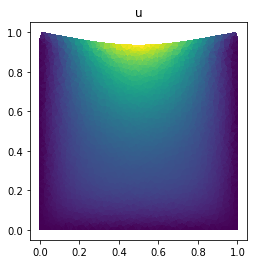

In [ ]:
plot(u, title='u', mode='displacement')

## General 5 field-formulation with hybrid coupling

In [ ]:
# mesh generation
#mesh = UnitSquareMesh(32, 32, 'crossed')
square = Rectangle(Point(0.0, 0.0), Point(1.0, 1.0))
mesh = generate_mesh(square, 32)

# definition of the lowest-order weak symmetry MFE coupling
S1 = FiniteElement('RT', mesh.ufl_cell(), 2)
S2 = FiniteElement('RT', mesh.ufl_cell(), 2)
U = VectorElement('DG', mesh.ufl_cell(), 1)
Q = FiniteElement('CG', mesh.ufl_cell(), 1)
W = FiniteElement('RT', mesh.ufl_cell(), 2)
P = FiniteElement('DG', mesh.ufl_cell(), 1)
X = FunctionSpace(mesh, MixedElement([S1, S2, U, Q, W, P]))

# problem data
lam = Constant(2e4)
mu  = Constant(1.2e5)
c_0 = Constant(0.0)
alpha = Constant(1.0)
kappa = Expression('near(x[0], 0.5, 0.2) & near(x[1], 0.5, 0.2) ? 0.01 : 0.000001', degree=0)
beta = Constant(0.1)
#beta = Expression('near(x[0], 0.5, 0.2) & near(x[1], 0.5, 0.2) ? 0.1 : 0.001', degree=0)

f = Constant([0.0]*2)   # volumetric force
g = Constant(0.0)       # fluid source term
dt = 0.01               # timestep
T = 0.05                 # final time

# method specific parameters
gamma = lam/(4*mu*(mu+lam))
delta = (alpha-beta)/(2*(mu+lam))
c_1 = c_0 + (alpha-beta)**2/(mu+lam)

# essential boundary condition
def top(x, on_boundary):
    return on_boundary and near(x[1], 1.0)

bc_0 = DirichletBC(X.sub(0), Constant((0.0, 0.0)), top)

# Define vertical traction TN such that TN \cdot n = t_n
class BoundaryTraction(UserExpression):
    def __init__(self, mesh, **kwargs):
        self.mesh = mesh
        super().__init__(**kwargs)
    def eval_cell(self, values, x, ufc_cell):
        cell = Cell(self.mesh, ufc_cell.index)
        n = cell.normal(ufc_cell.local_facet)
        t_n = 2e5*x[1]*x[0]*(x[0]-1)
        values[0] = t_n*n[0]
        values[1] = t_n*n[1]
    def value_shape(self):
        return (2,)

TN = BoundaryTraction(mesh, degree=2)
bc_1 = DirichletBC(X.sub(1), TN, top)

In [ ]:
# discrete problem formulation
s1, s2, u, q, w, phi = TrialFunctions(X)
t1, t2, v, r, z, psi = TestFunctions(X)
x_old = Function(X)
s1_old, s2_old, u_old, q_old, w_old, phi_old = x_old.split()

a1 = ((0.5/mu) * (dot(s1, t1)+dot(s2, t2)) - gamma * (s1[0]+s2[1]) * (t1[0]+t2[1])) * dx
a2 = (u[0] * div(t1) + u[1] * div(t2) - v[0] * div(s1) - v[1] * div(s2)) * dx
a3 = delta * ((t1[0]+t2[1]) * phi + (s1[0]+s2[1]) * psi) * dx
a4 = ((dt/kappa) * dot(w - (beta/dt)*u, z - (beta/dt)*v) + c_1 * phi * psi) * dx
a5 = dt *(psi * div(w) - phi * div(z)) * dx
a6 = (r * (s1[1] - s2[0]) - q * (t1[1] - t2[0])) * dx 
a = a1 + a2 + a3 + a4 + a5 + a6 

A = assemble(a)
bc_0.apply(A)
bc_1.apply(A)
Ainv = LUSolver(A)
    
L = (dot(f,v) + (dt*g+c_1*phi_old+delta*(s1_old[0]+s2_old[1]))*psi - (beta/kappa)*dot(u_old,z-(beta/dt)*v)) * dx

solving time 0.01
solving time 0.02
solving time 0.03
solving time 0.04
solving time 0.05


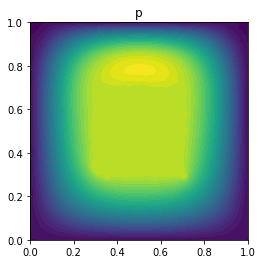

In [ ]:
# advance in time 
t = 0.0
u5mfile = File('5fdisp.pvd')
p5mfile = File('5fpres.pvd')
u5mfile << (u_old, t)
p5mfile << (phi_old, t)

for t in np.arange(dt, T+0.1*dt, dt):
    f.time = t
    g.time = t
    b = assemble(L)
    bc_0.apply(b)
    bc_1.apply(b)
        
    print('solving time {}'.format(t))
    Ainv.solve(x_old.vector(), b)
    s1_old, s2_old, u_old, q_old, w_old, phi_old = x_old.split()
    u5mfile << (u_old, t)
    p5mfile << (phi_old, t)

plot(phi_old, title='p')

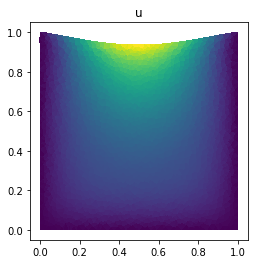

In [ ]:
plot(u_old, title='u', mode='displacement')

## 5 field-formulation with velocity-flux coupling 

In [ ]:
# mesh generation
#mesh = UnitSquareMesh(32, 32, 'crossed')
square = Rectangle(Point(0.0, 0.0), Point(1.0, 1.0))
mesh = generate_mesh(square, 32)

# definition of the lowest-order weak symmetry MFE coupling
S1 = FiniteElement('RT', mesh.ufl_cell(), 2)
S2 = FiniteElement('RT', mesh.ufl_cell(), 2)
U = VectorElement('DG', mesh.ufl_cell(), 1)
Q = FiniteElement('CG', mesh.ufl_cell(), 1)
W = FiniteElement('RT', mesh.ufl_cell(), 2)
P = FiniteElement('DG', mesh.ufl_cell(), 1)
X = FunctionSpace(mesh, MixedElement([S1, S2, U, Q, W, P]))

# problem data
lam = Constant(2e4)
mu  = Constant(1.2e5)
c_0 = Constant(0.0)
alpha = Constant(1.0)
kappa = Expression('near(x[0], 0.5, 0.2) & near(x[1], 0.5, 0.2) ? 0.01 : 0.000001', degree=0)

beta = 0.5/mu
gamma = lam/(4*mu*(mu+lam))

f = Constant([0.0]*2)   # volumetric force
g = Constant(0.0)       # fluid source term

dt = 0.01
T = 0.05

# essential boundary condition
def top(x, on_boundary):
    return on_boundary and near(x[1], 1.0)

bc_0 = DirichletBC(X.sub(0), Constant((0.0, 0.0)), top)

# Define vertical traction TN such that TN \cdot n = t_n
class BoundaryTraction(UserExpression):
    def __init__(self, mesh, **kwargs):
        self.mesh = mesh
        super().__init__(**kwargs)
    def eval_cell(self, values, x, ufc_cell):
        cell = Cell(self.mesh, ufc_cell.index)
        n = cell.normal(ufc_cell.local_facet)
        t_n = -2e5*x[1]*x[0]*(x[0]-1)
        values[0] = t_n*n[0]
        values[1] = t_n*n[1]
    def value_shape(self):
        return (2,)

TN = BoundaryTraction(mesh, degree=2)
bc_1 = DirichletBC(X.sub(1), TN, top)
bcs = [bc_0, bc_1]

In [ ]:
# discrete problem formulation
s1, s2, u, q, w, phi = TrialFunctions(X)
t1, t2, v, r, z, psi = TestFunctions(X)

x_old = Function(X)
s1_old, s2_old, u_old, q_old, w_old, phi_old = split(x_old)

a1 = (beta * (dot(s1, t1)+dot(s2, t2)) - gamma * (s1[0]+s2[1]) * (t1[0]+t2[1])) * dx
a2 = (-u[0] * div(t1) - u[1] * div(t2) + v[0] * div(s1) + v[1] * div(s2)) * dx
a3 = (1.0/(kappa * dt)) * dot(w - alpha * u, z - alpha *v) * dx
a4 = (psi * div(w) - phi * div(z) + c_0 * phi * psi) * dx
a5 = (r * (s1[1] - s2[0]) - q * (t1[1] - t2[0])) * dx
a = a1 + a2 + a3 + a4 + a5

L = (g*psi + (1.0/dt)*(dot(f, v) - v[0]*div(s1_old) - v[1]*div(s2_old) + phi_old*div(z))) * dx 

0.0
solving step 0.01
solving step 0.02
solving step 0.03
solving step 0.04
solving step 0.05


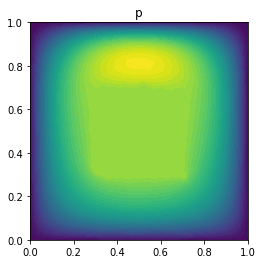

In [ ]:
# advance in time and post-process
time = 0.0
print(time)

x = Function(X)
s1, s2, u, q, w, phi = x.split()
u.rename('displacement', 'displacement')
phi.rename('pressure', 'pressure')

ufile = File('displacement.pvd')
ufile << (u, time)

while time < T:
  time += dt
  f.t = time
  g.t = time

  print('solving step {}'.format(time))
  x_old.assign(x)
  solve(a == L, x, bcs)
  x.assign(dt * x + x_old)

  s1, s2, u, q, w, phi = x.split()
  u.rename('displacement', 'displacement')
  phi.rename('pressure', 'pressure')
  ufile << (u, time)

plot(phi, title='p')